First we load the data. We will first show all the probabilitiy distributions in our dataset (prior, evidence, posterior, conditional probabilities).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.mixture import GaussianMixture

# Set font size for all plots
rcParams['font.size'] = 14
rcParams['axes.titlesize'] = 14
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['legend.fontsize'] = 14

# Create the dataset
data = {
    'Quizzes': [5.3, 5.5, 5.5, 5.0, 2.5, 3.0, 3.0, 3.1, 3.5, 3.5, 3.7, 4.0, 4.0, 4.0, 4.0, 5.7],
    'Labs': [5.3, 5.9, 5.29, 4.35, 5.5, 5.0, 4.0, 3.1, 4.5, 5.62, 5.0, 3.0, 4.0, 5.75, 4.44, 5.9],
    'Final': [4.818, 5.773, 4.464, 5.069, 4.164, 4.091, 3.727, 3.909, 3.518, 4.897, 5.209, 3.0, 3.091, 5.818, 4.069, 5.77]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Create pass/fail labels (1 for Pass, 0 for Fail)
df['Pass'] = df['Final'].apply(lambda x: 1 if x >= 4.0 else 0)

# Augment data by adding noise to create more points
np.random.seed(42)
augmented_data = []

# First, add the original data points
for i, row in df.iterrows():
    augmented_data.append({
        'Quizzes': row['Quizzes'],
        'Labs': row['Labs'],
        'Final': row['Final'],
        'Pass': row['Pass']
    })

# Then add 10 variations with noise for each original point
for i, row in df.iterrows():
    for j in range(10):
        # Create noise for each feature
        noise_quiz = np.random.normal(0, 0.2)
        noise_lab = np.random.normal(0, 0.2)
        noise_final = np.random.normal(0, 0.2)
        
        # Add noise and clip to range [2, 6]
        new_quiz = min(max(row['Quizzes'] + noise_quiz, 2), 6)
        new_lab = min(max(row['Labs'] + noise_lab, 2), 6)
        new_final = min(max(row['Final'] + noise_final, 2), 6)
        
        # Determine pass/fail based on noisy final score
        new_pass = 1 if new_final >= 4.0 else 0
        
        # Add to augmented data
        augmented_data.append({
            'Quizzes': new_quiz,
            'Labs': new_lab,
            'Final': new_final,
            'Pass': new_pass
        })

# Convert augmented data to DataFrame
df_aug = pd.DataFrame(augmented_data)

Now we look at the different distributions. Since we use the `fit` function, this is equivalent to computing the maximum likelihood of the overall dataset (before splitting according to "pass" or "fail". Here, we first fit a single gaussian distribution using `norm.fit`, and we also try with two gaussian (or the so called Gaussian Mixture model: `gmm.fit`. This is the evidence.


Augmented dataset class distribution:
Total: 176
Pass: 115 (65.34%)
Fail: 61 (34.66%)

Basic statistics for augmented features:
          Quizzes        Labs       Final
count  176.000000  176.000000  176.000000
mean     4.090401    4.764956    4.477691
std      0.984680    0.903926    0.916231
min      2.219630    2.710383    2.718507
25%      3.335569    4.189950    3.808585
50%      3.864825    4.965218    4.432312
75%      5.090206    5.496584    5.221640
max      6.000000    6.000000    6.000000


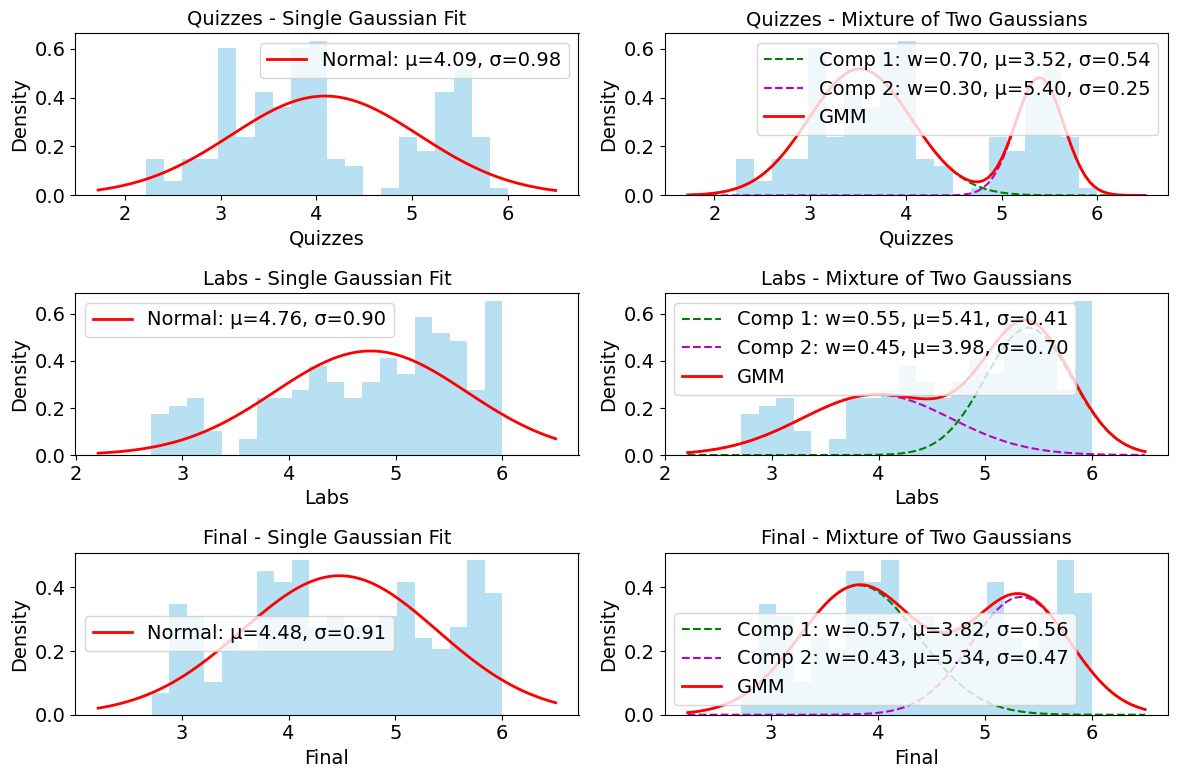

In [37]:
# Print class distribution in augmented data
print("\nAugmented dataset class distribution:")
print(f"Total: {len(df_aug)}")
print(f"Pass: {sum(df_aug['Pass'] == 1)} ({sum(df_aug['Pass'] == 1)/len(df_aug):.2%})")
print(f"Fail: {sum(df_aug['Pass'] == 0)} ({sum(df_aug['Pass'] == 0)/len(df_aug):.2%})")

# Basic statistics for each feature
print("\nBasic statistics for augmented features:")
print(df_aug[['Quizzes', 'Labs', 'Final']].describe())

# Create subplots for each feature
plt.figure(figsize=(12, 8))

# Define features to analyze
features = ['Quizzes', 'Labs', 'Final']

for i, feature in enumerate(features):
    # Extract data for this feature
    feature_data = df_aug[feature].values
    
    # Set up subplot
    plt.subplot(3, 2, 2*i+1)
    
    # Plot histogram
    plt.hist(feature_data, bins=20, density=True, alpha=0.6, color='skyblue')
    plt.title(f'{feature} - Single Gaussian Fit')
    plt.xlabel(feature)
    plt.ylabel('Density')
    
    # Fit single Gaussian (normal distribution)
    mu, std = norm.fit(feature_data)
    x = np.linspace(min(feature_data)-0.5, max(feature_data)+0.5, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'r-', linewidth=2, label=f'Normal: μ={mu:.2f}, σ={std:.2f}')
    plt.legend()
    
    # Add subplot for Gaussian Mixture Model (two components)
    plt.subplot(3, 2, 2*i+2)
    
    # Plot histogram again
    plt.hist(feature_data, bins=20, density=True, alpha=0.6, color='skyblue')
    plt.title(f'{feature} - Mixture of Two Gaussians')
    plt.xlabel(feature)
    plt.ylabel('Density')
    
    # Fit Gaussian Mixture Model with 2 components
    gmm = GaussianMixture(n_components=2, random_state=42)
    gmm.fit(feature_data.reshape(-1, 1))
    
    # Get GMM parameters
    weights = gmm.weights_
    means = gmm.means_.flatten()
    variances = gmm.covariances_.flatten()
    stds = np.sqrt(variances)
    
    # Plot the GMM components and their weighted sum
    x = np.linspace(min(feature_data)-0.5, max(feature_data)+0.5, 100)
    
    # Component 1
    p1 = weights[0] * norm.pdf(x, means[0], stds[0])
    plt.plot(x, p1, 'g--', linewidth=1.5, label=f'Comp 1: w={weights[0]:.2f}, μ={means[0]:.2f}, σ={stds[0]:.2f}')
    
    # Component 2
    p2 = weights[1] * norm.pdf(x, means[1], stds[1])
    plt.plot(x, p2, 'm--', linewidth=1.5, label=f'Comp 2: w={weights[1]:.2f}, μ={means[1]:.2f}, σ={stds[1]:.2f}')
    
    # Weighted sum (the GMM pdf)
    plt.plot(x, p1 + p2, 'r-', linewidth=2, label='GMM')
    plt.legend()

# Adjust layout
plt.tight_layout()
plt.savefig('gaussian_distributions.png')

Now we look at the class distributions for each feature. These are exactly the conditional probabilities (likelihoods) according to "pass" or "fail" status.

In [ ]:
# Compare the class distributions for each feature
plt.figure(figsize=(8, 8))

for i, feature in enumerate(features):
    plt.subplot(3, 1, i+1)
    
    # Separate data by class
    pass_data = df_aug[df_aug['Pass'] == 1][feature].values
    fail_data = df_aug[df_aug['Pass'] == 0][feature].values
    
    # Plot histograms for each class
    plt.hist(pass_data, bins=15, density=True, alpha=0.5, color='green', label='Pass')
    plt.hist(fail_data, bins=15, density=True, alpha=0.5, color='red', label='Fail')
    
    # Fit normal distributions to each class
    mu_pass, std_pass = norm.fit(pass_data)
    mu_fail, std_fail = norm.fit(fail_data)
    
    # Plot the distributions
    x = np.linspace(min(min(pass_data), min(fail_data))-0.5, max(max(pass_data), max(fail_data))+0.5, 100)
    plt.plot(x, norm.pdf(x, mu_pass, std_pass), 'g-', linewidth=2, 
             label=f'Pass: N({mu_pass:.2f}, {std_pass:.2f})')
    plt.plot(x, norm.pdf(x, mu_fail, std_fail), 'r-', linewidth=2, 
             label=f'Fail: N({mu_fail:.2f}, {std_fail:.2f})')
    
    plt.title(f'Distribution of {feature} by Class (Augmented Data)')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.savefig('class_distributions.png')

We also plot the prior probabilities (just proportions of the data according to "pass" or "fail" status).

P(C) - Prior Probabilities:
P(Pass) = 0.6534
P(Fail) = 0.3466


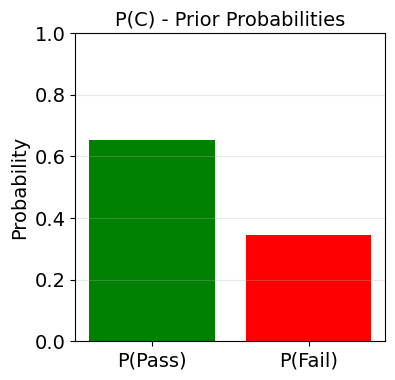

In [55]:
#  P(C) - Prior Probabilities
prior_pass = (df_aug['Pass'] == 1).mean()
prior_fail = (df_aug['Pass'] == 0).mean()

print("P(C) - Prior Probabilities:")
print(f"P(Pass) = {prior_pass:.4f}")
print(f"P(Fail) = {prior_fail:.4f}")


features = ['Quizzes', 'Labs', 'Final']


for i, feature in enumerate(features):
    # Extract data for this feature
    feature_data = df_aug[feature].values
    
    # Separate data by class
    pass_data = df_aug[df_aug['Pass'] == 1][feature].values
    fail_data = df_aug[df_aug['Pass'] == 0][feature].values
    
# plot prior probabilities
plt.figure(figsize=(4, 4))
bars = plt.bar(['P(Pass)', 'P(Fail)'], [prior_pass, prior_fail], color=['green', 'red'])


plt.title('P(C) - Prior Probabilities')
plt.ylabel('Probability')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.savefig('prior_probabilities.png', dpi=300)

Now we will develop a Naive Bayes model with this dataset.


Training set size: 123
Testing set size: 53


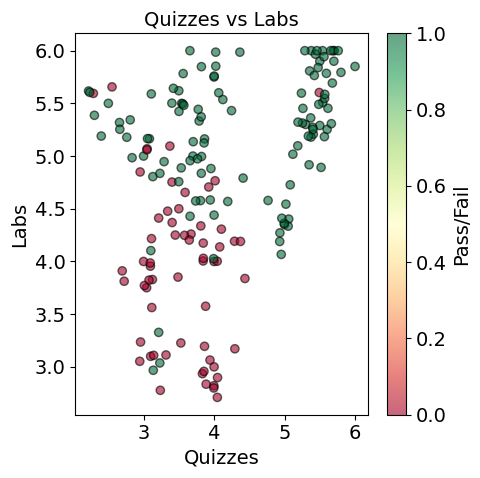

In [48]:
features = ['Quizzes', 'Labs']  

# Visualize the distribution of features by class
plt.figure(figsize=(5, 5))

    
# Separate data by class
pass_data = df_aug[df_aug['Pass'] == 1][feature]
fail_data = df_aug[df_aug['Pass'] == 0][feature]
    

scatter = plt.scatter(df_aug['Quizzes'], df_aug['Labs'], c=df_aug['Pass'], 
                     cmap=plt.cm.RdYlGn, alpha=0.6, edgecolors='k')
plt.colorbar(scatter, label='Pass/Fail')
plt.xlabel('Quizzes')
plt.ylabel('Labs')
plt.title('Quizzes vs Labs')

plt.tight_layout()
plt.savefig('feature_distributions.png')

# Split into predictors and target
X = df_aug[features]  # Only use Quizzes and Labs
y = df_aug['Pass']

# Split data into training (70%) and testing (30%) sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("\nTraining set size:", len(X_train))
print("Testing set size:", len(X_test))


In [49]:
#Here we define the Naive Bayes model (Gaussian because we deal with continous variables)

class GaussianNaiveBayes:
    def __init__(self):
        self.class_priors = {}
        self.feature_params = {}  # Will store mean and std for each feature for each class
        self.classes = None
        self.feature_names = None
    
    def fit(self, X, y, feature_names=None):
        # Store feature names if provided
        self.feature_names = feature_names if feature_names is not None else [f"Feature_{i}" for i in range(X.shape[1])]
        
        # Get unique classes
        self.classes = np.unique(y)
        n_samples, n_features = X.shape
        
        # Calculate class priors (P(y))
        for c in self.classes:
            self.class_priors[c] = np.mean(y == c)
        
        # Calculate feature statistics for each class (for P(x|y))
        for c in self.classes:
            X_c = X[y == c]
            self.feature_params[c] = {}
            
            for i, feature in enumerate(self.feature_names):
                self.feature_params[c][feature] = {
                    'mean': np.mean(X_c[:, i]),
                    'std': np.std(X_c[:, i]) + 1e-10  # Add small value to avoid division by zero
                }
    
    def _calculate_likelihood(self, x, mean, std):
        # Gaussian PDF: P(x|y) = (1 / (sqrt(2π) * σ)) * exp(-(x - μ)^2 / (2 * σ^2))
        exponent = -0.5 * ((x - mean) / std) ** 2
        return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(exponent)
    
    def _calculate_class_probability(self, x, c):
        # P(y|x) ∝ P(x|y) * P(y)
        # For multiple features, P(x|y) = P(x_1|y) * P(x_2|y) * ... * P(x_n|y)
        # Naive Bayes assumption: features are conditionally independent given the class
        
        # Calculate P(y)
        class_prior = self.class_priors[c]
        
        # Calculate P(x|y) for each feature and multiply
        likelihood = 1.0
        for i, feature in enumerate(self.feature_names):
            feature_mean = self.feature_params[c][feature]['mean']
            feature_std = self.feature_params[c][feature]['std']
            feature_likelihood = self._calculate_likelihood(x[i], feature_mean, feature_std)
            likelihood *= feature_likelihood
        
        # Return P(x|y) * P(y) (unnormalized P(y|x))
        return likelihood * class_prior
    
    def predict_proba(self, X):
        # For each sample, calculate probability for each class
        n_samples = X.shape[0]
        probas = np.zeros((n_samples, len(self.classes)))
        
        for i, x in enumerate(X):
            # Calculate unnormalized probabilities
            class_probas = np.array([self._calculate_class_probability(x, c) for c in self.classes])
            
            # Normalize to get P(y|x)
            if np.sum(class_probas) > 0:
                probas[i] = class_probas / np.sum(class_probas)
            else:
                # If all probabilities are very close to zero, use uniform distribution
                probas[i] = np.ones(len(self.classes)) / len(self.classes)
        
        return probas
    
    def predict(self, X):
        # Predict class with highest probability
        probas = self.predict_proba(X)
        return self.classes[np.argmax(probas, axis=1)]


In [50]:
# Train the Naive Bayes classifier
nb_classifier = GaussianNaiveBayes()
nb_classifier.fit(X_train.values, y_train.values, feature_names=X_train.columns)

# Print the learned parameters
print("\nNaive Bayes Model Parameters:")
print(f"Prior P(Pass) = {nb_classifier.class_priors[1]:.4f}")
print(f"Prior P(Fail) = {nb_classifier.class_priors[0]:.4f}")

print("\nFeature distributions for Pass class:")
for feature in features:
    mean = nb_classifier.feature_params[1][feature]['mean']
    std = nb_classifier.feature_params[1][feature]['std']
    print(f"{feature}: μ = {mean:.4f}, σ = {std:.4f}")

print("\nFeature distributions for Fail class:")
for feature in features:
    mean = nb_classifier.feature_params[0][feature]['mean']
    std = nb_classifier.feature_params[0][feature]['std']
    print(f"{feature}: μ = {mean:.4f}, σ = {std:.4f}")

# Make predictions on test set
y_pred = nb_classifier.predict(X_test.values)
y_pred_proba = nb_classifier.predict_proba(X_test.values)

# Calculate accuracy
accuracy = np.mean(y_pred == y_test.values)
print(f"\nAccuracy: {accuracy:.4f}")

# Display confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Naive Bayes Model Parameters:
Prior P(Pass) = 0.6341
Prior P(Fail) = 0.3659

Feature distributions for Pass class:
Quizzes: μ = 4.3037, σ = 1.0396
Labs: μ = 5.1497, σ = 0.6701

Feature distributions for Fail class:
Quizzes: μ = 3.5510, σ = 0.5428
Labs: μ = 3.8211, σ = 0.7326

Accuracy: 0.8679

Confusion Matrix:
[[10  6]
 [ 1 36]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.62      0.74        16
         1.0       0.86      0.97      0.91        37

    accuracy                           0.87        53
   macro avg       0.88      0.80      0.83        53
weighted avg       0.87      0.87      0.86        53



In [ ]:
The parameters of each distribution are found using MLE (using the `fit`function).

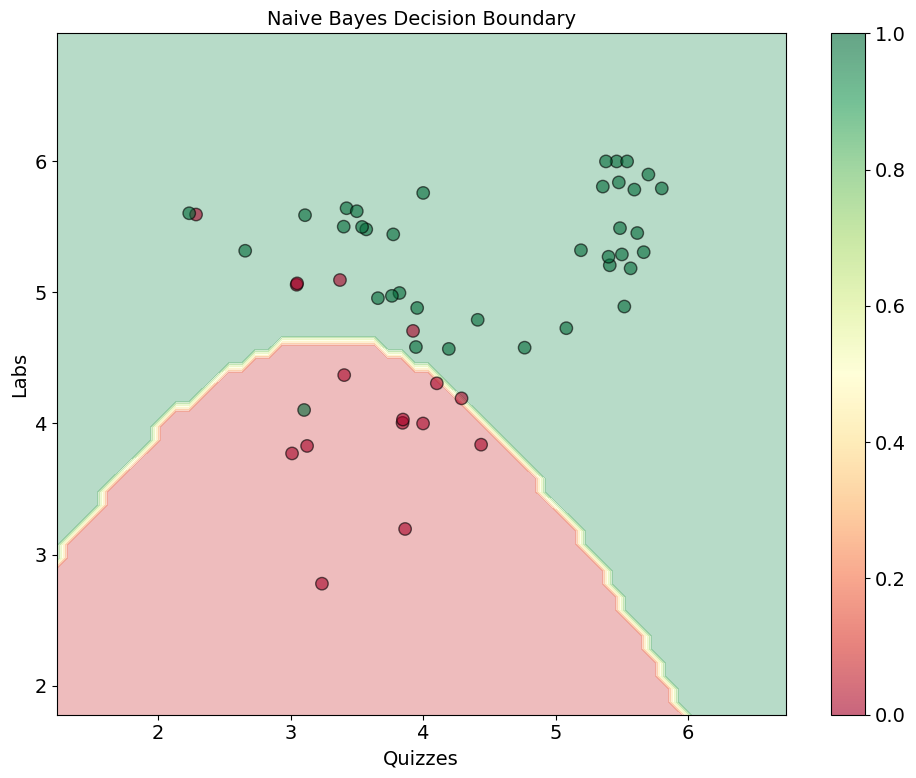

In [54]:
# Create a function to visualize the decision boundary
def plot_decision_boundary(classifier, X, y, title="Decision Boundary"):
    h = 0.1  # Step size in the mesh
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict for each point in the mesh
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlGn)
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=plt.cm.RdYlGn, 
                edgecolors='k', marker='o', s=80, alpha=0.6)
    
    plt.title(title)
    plt.xlabel(X.columns[0])
    plt.ylabel(X.columns[1])
    plt.colorbar()
    plt.tight_layout()
    plt.savefig('decision_boundary.png')

# Plot decision boundary
plot_decision_boundary(nb_classifier, X_test, y_test, "Naive Bayes Decision Boundary")


Example Student:
Quizzes: 3.95
Labs: 4.58
Actual outcome: Pass

Bayesian Calculation for x = [3.94611863 4.58350845]:
Prior P(Pass) = 0.6341
Prior P(Fail) = 0.3659

Likelihood for Quizzes:
P(Quizzes=3.95 | Pass) = 0.36171346
P(Quizzes=3.95 | Fail) = 0.56390025

Likelihood for Labs:
P(Labs=4.58 | Pass) = 0.41662526
P(Labs=4.58 | Fail) = 0.31687347

Joint Likelihoods (using independence assumption):
P(x | Pass) = 0.15069896
P(x | Fail) = 0.17868503

Unnormalized posteriors:
P(Pass | x) ∝ P(x | Pass) × P(Pass) = 0.09556520
P(Fail | x) ∝ P(x | Fail) × P(Fail) = 0.06537257

Normalized posteriors:
P(Pass | x) = 0.5938
P(Fail | x) = 0.4062

Prediction: Pass

Demonstrating the impact of different priors:
Original prior P(Pass) = 0.6341

With prior P(Pass) = 0.1000:
Posterior P(Pass | x) = 0.0857
Posterior P(Fail | x) = 0.9143
Prediction: Fail

With prior P(Pass) = 0.3000:
Posterior P(Pass | x) = 0.2655
Posterior P(Fail | x) = 0.7345
Prediction: Fail

With prior P(Pass) = 0.5000:
Posterior P(P

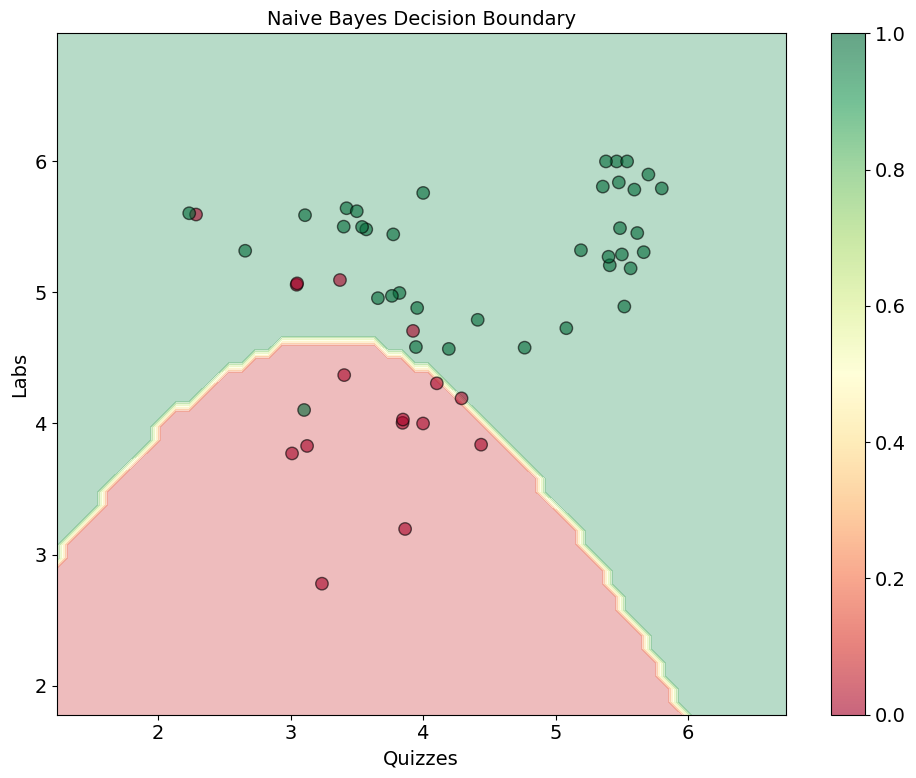

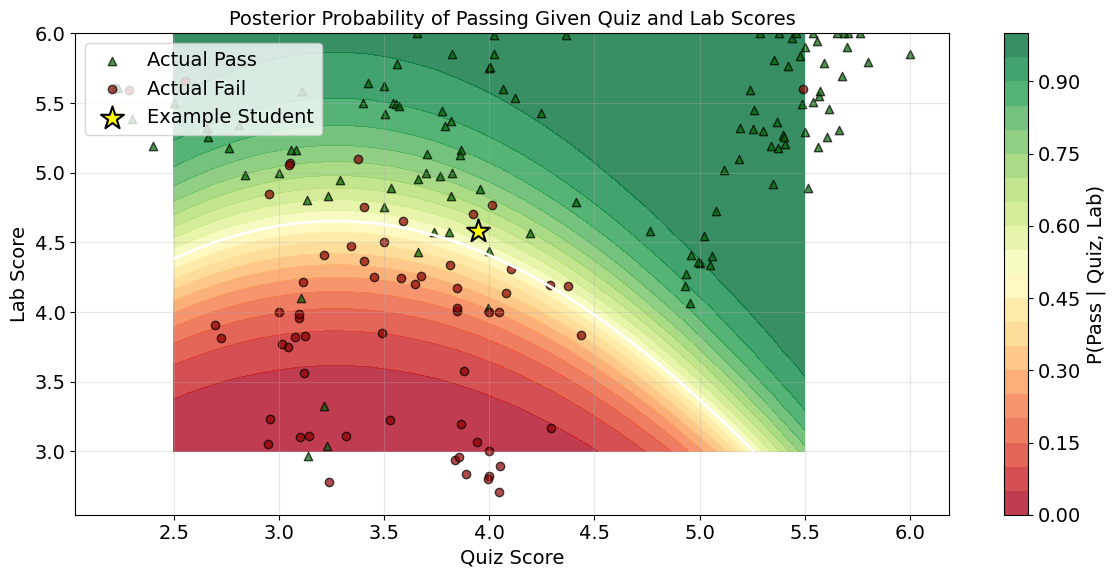

In [ ]:
# Show the Bayesian calculation for a specific example
def explain_naive_bayes_prediction(classifier, x, feature_names):
    print(f"\nBayesian Calculation for x = {x}:")
    
    # Calculate class priors
    prior_pass = classifier.class_priors[1]
    prior_fail = classifier.class_priors[0]
    print(f"Prior P(Pass) = {prior_pass:.4f}")
    print(f"Prior P(Fail) = {prior_fail:.4f}")
    
    # Calculate likelihoods P(x|y) for each feature and class
    pass_likelihoods = []
    fail_likelihoods = []
    
    for i, feature in enumerate(feature_names):
        pass_mean = classifier.feature_params[1][feature]['mean']
        pass_std = classifier.feature_params[1][feature]['std']
        pass_likelihood = classifier._calculate_likelihood(x[i], pass_mean, pass_std)
        pass_likelihoods.append(pass_likelihood)
        
        fail_mean = classifier.feature_params[0][feature]['mean']
        fail_std = classifier.feature_params[0][feature]['std']
        fail_likelihood = classifier._calculate_likelihood(x[i], fail_mean, fail_std)
        fail_likelihoods.append(fail_likelihood)
        
        print(f"\nLikelihood for {feature}:")
        print(f"P({feature}={x[i]:.2f} | Pass) = {pass_likelihood:.8f}")
        print(f"P({feature}={x[i]:.2f} | Fail) = {fail_likelihood:.8f}")
    
    # Calculate joint likelihoods (using naive independence assumption)
    joint_pass_likelihood = np.prod(pass_likelihoods)
    joint_fail_likelihood = np.prod(fail_likelihoods)
    
    print("\nJoint Likelihoods (using independence assumption):")
    print(f"P(x | Pass) = {joint_pass_likelihood:.8f}")
    print(f"P(x | Fail) = {joint_fail_likelihood:.8f}")
    
    # Calculate unnormalized posteriors
    posterior_pass = joint_pass_likelihood * prior_pass
    posterior_fail = joint_fail_likelihood * prior_fail
    
    print("\nUnnormalized posteriors:")
    print(f"P(Pass | x) ∝ P(x | Pass) × P(Pass) = {posterior_pass:.8f}")
    print(f"P(Fail | x) ∝ P(x | Fail) × P(Fail) = {posterior_fail:.8f}")
    
    # Calculate evidence (normalization factor)
    evidence = posterior_pass + posterior_fail
    
    # Calculate normalized posteriors
    normalized_pass = posterior_pass / evidence
    normalized_fail = posterior_fail / evidence
    
    print("\nNormalized posteriors:")
    print(f"P(Pass | x) = {normalized_pass:.4f}")
    print(f"P(Fail | x) = {normalized_fail:.4f}")
    
    # Make prediction
    prediction = "Pass" if normalized_pass > normalized_fail else "Fail"
    print(f"\nPrediction: {prediction}")

# Choose a test example to explain
example_idx = 11  # Choosing the 11th sample from the test set
example_x = X_test.iloc[example_idx].values
example_y = y_test.iloc[example_idx]

print(f"\nExample Student:")
print(f"Quizzes: {example_x[0]:.2f}")
print(f"Labs: {example_x[1]:.2f}")
print(f"Actual outcome: {'Pass' if example_y == 1 else 'Fail'}")

# Explain the prediction for this example
explain_naive_bayes_prediction(nb_classifier, example_x, X_test.columns)

# Visualize the impact of evidence on predictions
plt.figure(figsize=(12, 6))

# Create a grid of quiz and lab scores
quiz_range = np.linspace(2.5, 5.5, 30)
lab_range = np.linspace(3.0, 6.0, 30)
quiz_grid, lab_grid = np.meshgrid(quiz_range, lab_range)

# Calculate posterior probability of passing for each grid point
posterior_pass = np.zeros_like(quiz_grid)

for i in range(len(quiz_range)):
    for j in range(len(lab_range)):
        x = np.array([quiz_grid[j, i], lab_grid[j, i]])
        proba = nb_classifier.predict_proba(x.reshape(1, -1))[0]
        posterior_pass[j, i] = proba[1]  # Probability of Pass

# Plot the posterior probability heatmap
plt.contourf(quiz_grid, lab_grid, posterior_pass, levels=20, cmap='RdYlGn', alpha=0.8)
plt.colorbar(label='P(Pass | Quiz, Lab)')

# Add scatter plot of actual students
plt.scatter(df_aug[df_aug['Pass']==1]['Quizzes'], df_aug[df_aug['Pass']==1]['Labs'], 
            c='darkgreen', marker='^', edgecolors='k', alpha=0.7, label='Actual Pass')
plt.scatter(df_aug[df_aug['Pass']==0]['Quizzes'], df_aug[df_aug['Pass']==0]['Labs'], 
            c='darkred', marker='o', edgecolors='k', alpha=0.7, label='Actual Fail')

# Add decision boundary
plt.contour(quiz_grid, lab_grid, posterior_pass, levels=[0.5], colors='white', linewidths=2)

# Highlight our example student
plt.scatter([example_x[0]], [example_x[1]], c='yellow', marker='*', 
            s=300, edgecolors='black', linewidths=1.5, label='Example Student')

plt.title('Posterior Probability of Passing Given Quiz and Lab Scores')
plt.xlabel('Quiz Score')
plt.ylabel('Lab Score')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('posterior_probability_map.png')

# Demonstrate how predictions might change with different prior probabilities
print("\nDemonstrating the impact of different priors:")

# Original prior
original_prior_pass = nb_classifier.class_priors[1]
print(f"Original prior P(Pass) = {original_prior_pass:.4f}")

# Let's try different priors
alternative_priors = [0.1, 0.3, 0.5, 0.7, 0.9]

for alt_prior_pass in alternative_priors:
    # Create a copy of our classifier with modified priors
    alt_classifier = GaussianNaiveBayes()
    
    # Copy over the feature parameters
    alt_classifier.feature_params = nb_classifier.feature_params
    alt_classifier.classes = nb_classifier.classes
    alt_classifier.feature_names = nb_classifier.feature_names
    
    # Set new priors
    alt_classifier.class_priors = {
        1: alt_prior_pass,
        0: 1 - alt_prior_pass
    }
    
    # Predict for our example
    proba = alt_classifier.predict_proba(example_x.reshape(1, -1))[0]
    prediction = "Pass" if proba[1] > 0.5 else "Fail"
    
    print(f"\nWith prior P(Pass) = {alt_prior_pass:.4f}:")
    print(f"Posterior P(Pass | x) = {proba[1]:.4f}")
    print(f"Posterior P(Fail | x) = {proba[0]:.4f}")
    print(f"Prediction: {prediction}")

The naive Bayes classifier applies Bayes' rule to make predictions. It's 'naive' because it assumes features are conditionally independent. The prior probabilities are based on the class distribution in the training data. 
The likelihood is calculated using feature distributions for each class. The posterior combines prior knowledge with the evidence from the features. Changing the prior directly impacts the decision boundary and predictions.